# 2D Phase Diagram

In [1]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import * 

<IPython.core.display.Javascript object>

## Load Json Data
* To compute the phase diagram inside the notebook is not pratical as it's very computationally expensive. The job is done in a multi-process pool routine which generates data that can be loaded and present here.

In [30]:
import sys
import os
import inspect
from os.path import join
import json
from json import dumps
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
files = []
for i in [7]: # designed to support multiple files
    files.append(f"2d_phase_map_data_0{i}.txt")
rets = []
for file in files:
    file = join(currentdir,"../",file)
    if os.path.exists(file):
        with open(file,'r') as rf:
            rets.extend(json.load(rf))
files

['2d_phase_map_data_07.txt']

### Data format
* The overall data is a list, each item in the list is a dict with 3 entries,  **mu** and **delta**($\Delta_0$), and **data**
* The format of the **data** is a list of array, each array is a tuple of 5 numbers,  corresond to: ($d\mu$, dq, g, $\Delta$, pressure). The $\Delta$ is the new value when dq and dmu are not zero, so it may be different from the $\Delta$ in the dict.



#### The piece of code in the following cell find the maximum pressure for given(mu, $\Delta_0$, dmu), which can determine if dq is zero or not

In [32]:
formattedData = []
#find the dq with maximum pressure
for items in rets:
    mu = items['mu']
    delta = items['delta']
    data = items['data']
    if len(data) > 0:
        ret = data[0]
        dmu,dq, g, d, p,na,nb = ret
        for item in data:
            if dmu == item[0]:
                if item[4] > p:
                    dq = item[1]
                    p = item[4]
            else:
                formattedData.append((mu, g, dmu, dq, delta))
                dmu, dq, g, d, p, na, nb = item
        formattedData.append((mu, g, dmu, dq, delta))

### Compute density
* Take couple of minutes to compute the density

In [33]:
from mmf_hfb import FuldeFerrelState; reload(FuldeFerrelState)
ff = FuldeFerrelState.FFState(fix_g=True,k_c=500)
data = []
for i in range(len(formattedData)):
    mu, g, dmu, dq, delta = formattedData[i]
    na, nb = ff.get_densities(mu=mu, dmu=0, delta=delta)
    data.append(formattedData[i] + (na.n, nb.n,))

E:\Projects\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\integrate.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return ufloat(*sp.integrate.quad(func=func, a=a, b=b, points=points, **kw))


### Plot the phase diagram

Text(0, 0.5, '$d\\mu/\\Delta_0$')

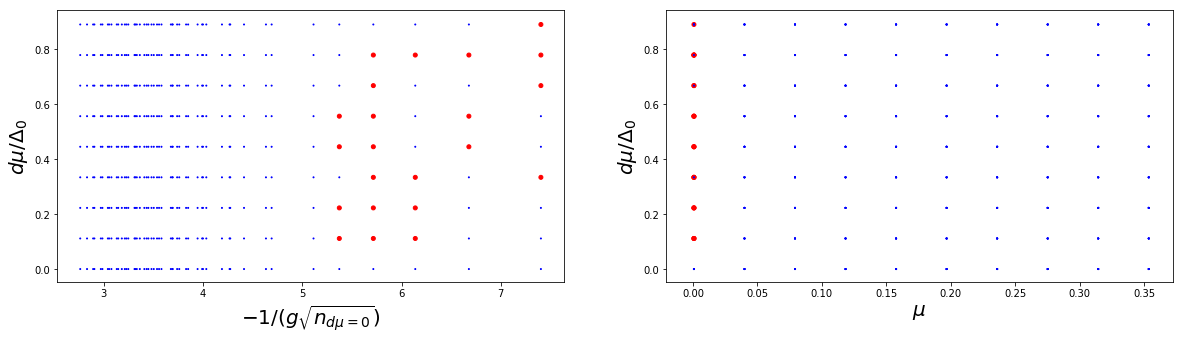

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
x,y,c,area =[],[],[],[]
for item in data:
    n = item[5] + item[6]
    x.append(-1.0/(item[1] * np.sqrt(n)))
    y.append(item[2]/item[4])
    if item[2] > 0 and item[3] > 0:
        c.append('r')
        area.append(16)
    else:
        c.append('b')
        area.append(1)
plt.scatter(x, y, s=area, c=c)
plt.xlabel(r"$-1/(g\sqrt{n_{d\mu=0}})$", fontsize=20)
plt.ylabel(r"$d\mu/\Delta_0$", fontsize=20)
plt.subplot(122)
x,y=[],[]
for item in data:
    x.append(item[4])
    y.append(item[2]/item[4])

plt.scatter(x, y, s=area, c=c)
plt.xlabel(r"$\mu$", fontsize=20)
plt.ylabel(r"$d\mu/\Delta_0$", fontsize=20)

# Check derivatives
mu, g, dmu, dq, delta, na, nb
* Pick a FF state
* $\mu=0.5$
* g=-0.46649458220982054
* $d\mu=0.00039283710065919316$ 
* $dq=7.856742013183863e-05$
* $\Delta=0.0007071067811865476$
* $n_a=0.07957751184849551$
* $n_b=0.07957751184849551$)

Pressue is a function of $\Delta$, $\mu$, $d\mu$, q, and dq:

$$
\newcommand{\E}{\mathcal{E}}
P(\Delta, \mu,d\mu, q, dq)= n_a(\Delta, \mu,d\mu, q, dq) \mu_a + n_b(\Delta, \mu,d\mu, q, dq) \mu_b -\E(\Delta, \mu,d\mu, q, dq)
$$
where 
$$
\E = \kappa\\
n_a = \frac{n_+ + n_-}{2} \qquad
n_b = \frac{n_+ - n_-}{2}\qquad
\mu_a = \frac{\mu_+ + \mu_-}{2}\qquad
\mu_b = \frac{\mu_+ - \mu_-}{2}\qquad
$$

\begin{align}
\newcommand\intdk{\int\frac{\d^d{k}}{(2\pi)^d}\;}
  n_+ &= \intdk\overbrace{\left(1 - \frac{\epsilon^+_k}{E_k}
               \underbrace{\bigl(f(\omega_-) - f(\omega_+)\bigr)}_{f_\nu}
          \right)}^{f_+}, &
  n_- &= \intdk\overbrace{\bigl(f(\omega_+) - f(-\omega_-)\bigr)}^{f_-},\\
  \tau_+ &= \intdk k^2f_+, &
  \tau_- &= \intdk k^2f_-,\\
  \nu &= -\intdk\frac{\Delta}{2E_k}\overbrace{\bigl(f(\omega_-)-f(\omega_+)\bigr)}^{f_\nu}, &
  \kappa &= \intdk \left(\frac{\hbar^2k^2}{2m_+}f_+ 
                         - \frac{\abs{\Delta}^2}{2E_k}f_\nu\right),\\
\end{align}

Using the chain rule, we may be able to find the condition that maximize the pressure:
\begin{align}
\frac{\partial P}{\partial dq} &= 0\\
&=\frac{\partial n_a}{\partial dq}\mu_a + \frac{\partial n_b}{\partial dq}\mu_b -\frac{\partial \kappa}{\partial dq}\\
&=\frac{\partial (n_+ + n_-)}{4\partial dq}(\mu_+ + \mu_-) + \frac{\partial (n_+ - n_-)}{4\partial dq}(\mu_+ - \mu_-) -\frac{\partial \kappa}{\partial dq}\\
&=\frac{\partial n_+}{2\partial dq}\mu_+ + \frac{\partial n_-}{2\partial dq}\mu_- -\frac{\partial \kappa}{\partial dq}
\end{align}
With this we can perform chain rules:

$$
\epsilon_a = \frac{\hbar^2}{2m}k_a^2 - \mu_a, \qquad \epsilon_b = \frac{\hbar^2}{2m}k_b^2 - \mu_b\\
\epsilon_+ = \frac{\hbar^2}{2m}(k_a^2+k_b^2) - \mu_+, \qquad \epsilon_- = \frac{\hbar^2}{2m}(k_a^2-k_b^2) - \mu_-\\
E=\sqrt{\epsilon_+^2+\abs{\Delta}^2},\qquad \omega_+= \epsilon_-+E, \qquad \omega_- = \epsilon_- - E
$$
$$
\frac{\partial n+}{\partial dq}=\intdk\left[ \frac{\partial}{\partial dq}\left(\frac{\epsilon^+}{E}\right)f_{\nu} + \frac{\epsilon^+}{E} \frac{\partial}{\partial dq}f_{\nu}\right]
$$